# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
from skimage.io import imread
from scipy import ndimage
import trackpy as tp
from cellpose import models
from cellpose import plot
from matplotlib import gridspec
import math
import seaborn as sn                        # Library for advanced plotting
from joblib import Parallel, delayed
import multiprocessing
from numpy import unravel_index

# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import tifffile
import sys
from skimage.exposure import rescale_intensity
import rsnapsim as rss
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','moving_cells')
masks_dir = current_dir.parents[1].joinpath('DataBases','masks_for_sim_cell')
trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')

In [3]:
#import rsnaped as rsp
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp
rsp.Banner(show=True).print_banner()

 
  ██████╗░░██████╗███╗░░██╗░█████╗░██████╗░███████╗██████╗░ 
  ██╔══██╗██╔════╝████╗░██║██╔══██╗██╔══██╗██╔════╝██╔══██╗ 
  ██████╔╝╚█████╗░██╔██╗██║███████║██████╔╝█████╗░░██║░░██║ 
  ██╔══██╗░╚═══██╗██║╚████║██╔══██║██╔═══╝░██╔══╝░░██║░░██║ 
  ██║░░██║██████╔╝██║░╚███║██║░░██║██║░░░░░███████╗██████╔╝ 
             by : L. Aguilera, T. Stasevich, and B. Munsky 


In [4]:
# List all video in dir
video_dir
list_files_names = sorted([f for f in listdir(video_dir) if isfile(join(video_dir, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
path_files

['/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos1.ome.tif',
 '/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos4.ome.tif',
 '/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos6.ome.tif']

In [5]:
path_files

['/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos1.ome.tif',
 '/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos4.ome.tif',
 '/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos6.ome.tif']

In [6]:
use_GPU = True # models.use_gpu()

In [7]:
file_path = pathlib.Path(path_files[0])
video = imread(str(file_path)) 
img = np.expand_dims(video,axis=3)
print(img.shape)

(55, 1024, 1024, 1)


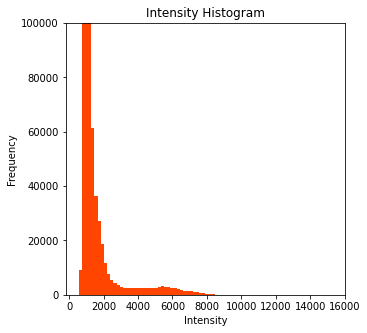

In [8]:
# Plotting the intensity distribution for a specific time point and an specific channel
plt.figure(figsize=(5,5))
plt.hist(img[0].flatten(), bins=80,color='orangered')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.ylim(0,1e5)
plt.title('Intensity Histogram')
plt.show()

In [9]:
img2= np.concatenate((img,img),axis=3)
img2.shape

(55, 1024, 1024, 2)

In [10]:
number_columns = 15
list_time_points = np.linspace(0,img.shape[0], number_columns,endpoint=False, dtype=int)

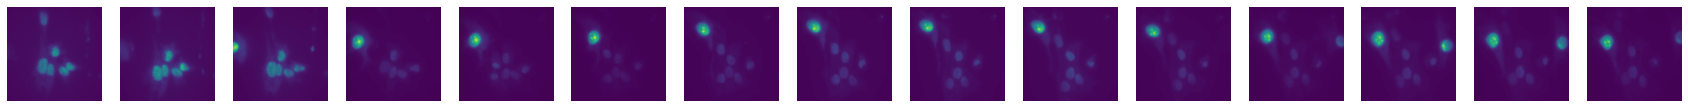

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=number_columns, figsize=(30, 5))
for i, selected_time in enumerate(list_time_points):
    ax[i].imshow(img2[selected_time,:,:,0])
    ax[i].axis('off')

In [12]:
img3 = img2.copy() # Making a copy of our img
img3[img3>3000]=3000  # threshold image values larger than 1000 equal to 1000

In [13]:
model = models.Cellpose(gpu=use_GPU, model_type='nuclei') # model_type='cyto' or model_type='nuclei'

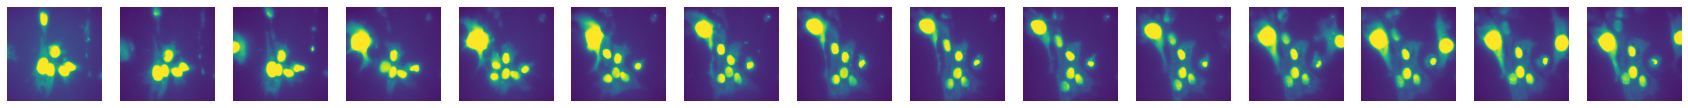

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=number_columns, figsize=(30, 5))
for i, selected_time in enumerate(list_time_points):
    ax[i].imshow(img3[selected_time,:,:,0])
    ax[i].axis('off')

In [64]:
list_masks_for_all_frames, _, _, _ = model.eval(img3, diameter=80, min_size=500, channels=[0,0], net_avg=False, augment=False,flow_threshold=1)
list_masks_for_all_frames.shape

(55, 1024, 1024)

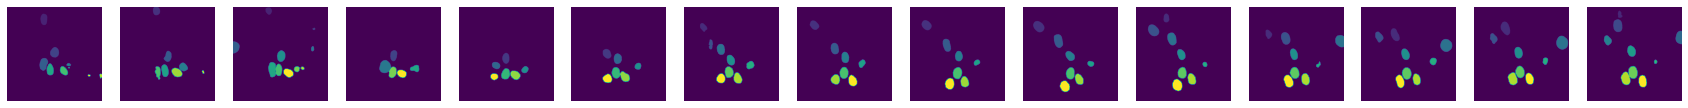

In [16]:
# Plotting the  masks founds for every frame.
fig, ax = plt.subplots(nrows=1,ncols=number_columns, figsize=(30, 5))
for i, selected_time in enumerate(list_time_points):
    ax[i].imshow(list_masks_for_all_frames[selected_time])
    ax[i].axis('off')

In [17]:
# Creating dataframe with centers of mass
list_df=[]
test=[]
test=np.array(test)
number_frames= img.shape[0]
for i in range(number_frames):
    number_cells_in_frame = list_masks_for_all_frames[i].max()
    for m in range (1, number_cells_in_frame+1):
        selected_mask = np.where(list_masks_for_all_frames[i]==m,1,0) # Selecting only one mask.  
        x,y = ndimage.measurements.center_of_mass(selected_mask)
        list_df.append( [i,int(x),int(y)] )
        del x, y, selected_mask
arr = np.array(list_df)

In [18]:
df = pd.DataFrame(arr, columns=['frame', 'y', 'x'])
#print(df)

In [19]:
tp.quiet()  # Turn off progress reports for best performance
t = tp.link(df, memory=1,search_range=100)
print('Number of particles: ', t['particle'].nunique())

Number of particles:  30


In [20]:
t_filtered = tp.filter_stubs(t, 5)  # selecting trajectories that appear in at least 10 frames.
print('Number of particles after filter: ', t_filtered['particle'].nunique())

Number of particles after filter:  11


In [21]:
t_filtered.head()

,frame,y,x,particle
frame,,,,
0,0,143,397,0
0,0,500,513,1
0,0,625,394,2
0,0,686,464,5
0,0,699,612,6


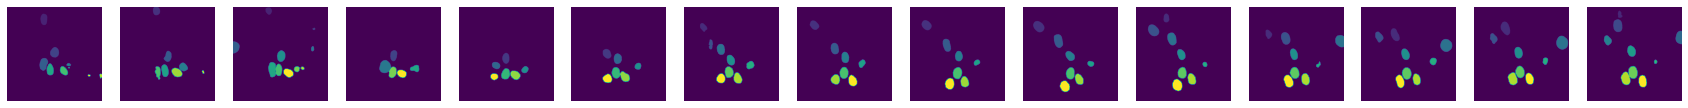

In [22]:
# Plotting the  masks founds for every frame.
fig, ax = plt.subplots(nrows=1,ncols=number_columns, figsize=(30, 5))
for i, selected_time in enumerate(list_time_points):
    ax[i].imshow(list_masks_for_all_frames[selected_time])
    ax[i].axis('off')

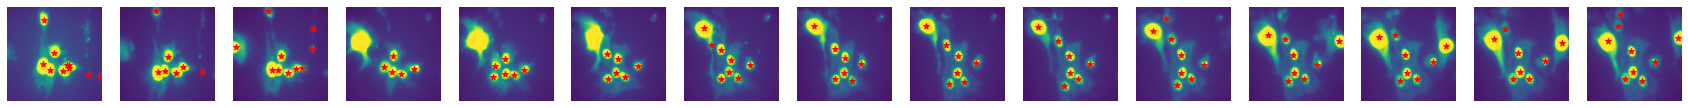

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=number_columns, figsize=(30, 5))
for i, selected_time in enumerate(list_time_points):
    # positions
    x_val = t.loc[t['frame']==selected_time ].x.values
    y_val = t.loc[t['frame']==selected_time ].y.values
    ax[i].imshow(img3[selected_time,:,:,0])
    ax[i].scatter(x_val,y_val,c='r',marker='*')
    ax[i].axis('off')
    del x_val, y_val

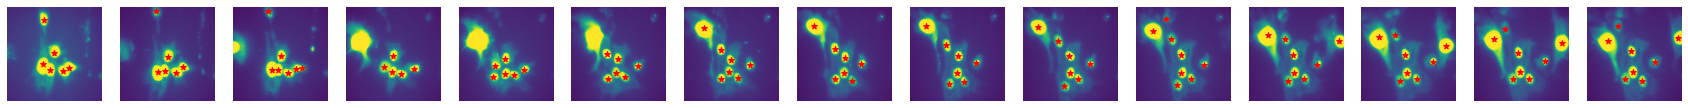

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=number_columns, figsize=(30, 5))
for i, selected_time in enumerate(list_time_points):
    # positions
    x_val = t_filtered.loc[t_filtered['frame']==selected_time ].x.values
    y_val = t_filtered.loc[t_filtered['frame']==selected_time ].y.values
    ax[i].imshow(img3[selected_time,:,:,0])
    ax[i].scatter(x_val,y_val,c='r',marker='*')
    ax[i].axis('off')
    del x_val, y_val

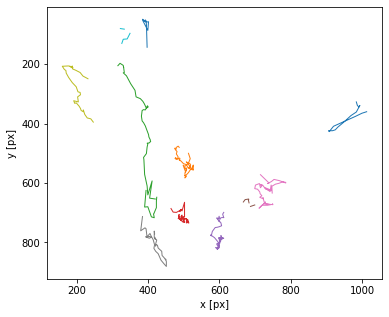

In [25]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
#ax[0] = tp.plot_traj(t)
ax = tp.plot_traj(t_filtered)
plt.show()

In [26]:
list_df=[]
number_frames= img.shape[0]
list_new_masks= []
for i in range(0,number_frames):
    # creating a copy of the original image
    temp_image = np.zeros_like(list_masks_for_all_frames[i])
    trackpy_labels = t_filtered.loc[t_filtered['frame']==i ].particle.values
    # Iterate for each cell in 
    number_cells_in_frame = list_masks_for_all_frames[i].max()
    for m in range (1, number_cells_in_frame+1):
        selected_mask = np.where(list_masks_for_all_frames[i]==m,1,0) # Selecting only one mask.  
        for index, particle_label in enumerate (trackpy_labels):
            # Test if the center of mass is inside the selected mask 
            y, x = t_filtered.loc[(t_filtered['frame']==i ) & (t_filtered['particle']==particle_label) , ['y', 'x']].values[0]
            if selected_mask[y,x]==1:
                temp_image = np.where(selected_mask==1, particle_label,temp_image)
    list_new_masks.append(temp_image)
new_masks = np.array(list_new_masks)

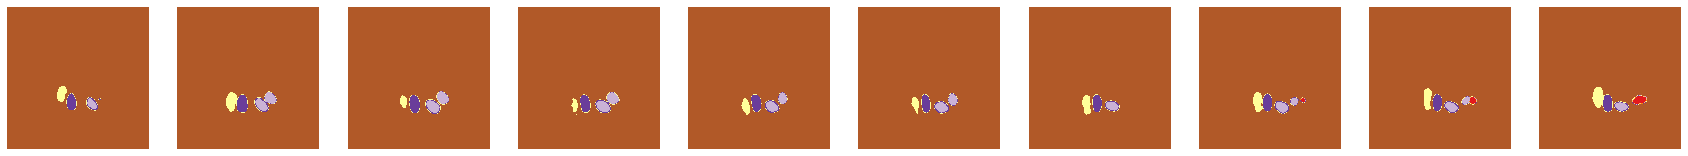

In [27]:
number_columns = 10
list_time_points = np.arange(0,number_columns )
# Plotting the  masks founds for every frame.
fig, ax = plt.subplots(nrows=1,ncols=number_columns, figsize=(30, 7))
for i, selected_time in enumerate(list_time_points):
    ax[i].imshow(new_masks[selected_time], cmap = 'Paired_r',vmin=0,vmax=new_masks.max())
    ax[i].axis('off')

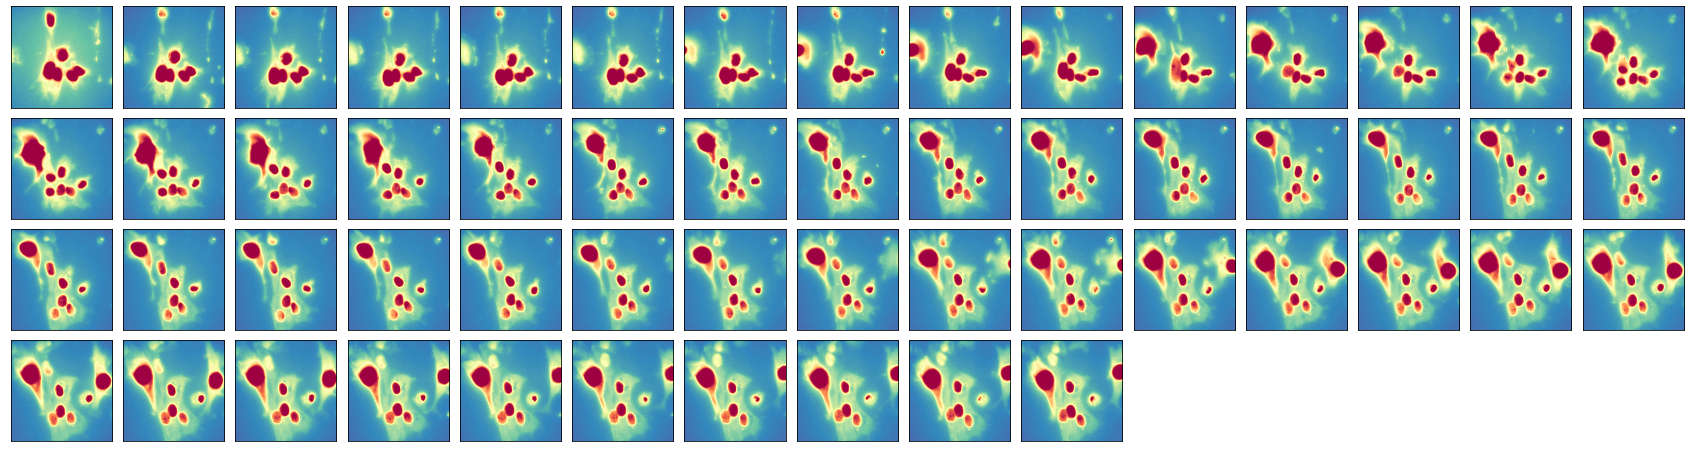

In [28]:
number_columns = 15
number_images = new_masks.shape[0]
number_rows = math.ceil(number_images/number_columns)
individual_figure_size = 2
# Loop to plot multiple cells in a grid
gs = gridspec.GridSpec(number_rows, number_columns)
gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
for index_image in range(0, number_images):
    ax = fig.add_subplot(gs[index_image])
    ax.imshow(img3[index_image,:,:,0], cmap = 'Spectral_r')
    ax.set_xticks([]); ax.set_yticks([])

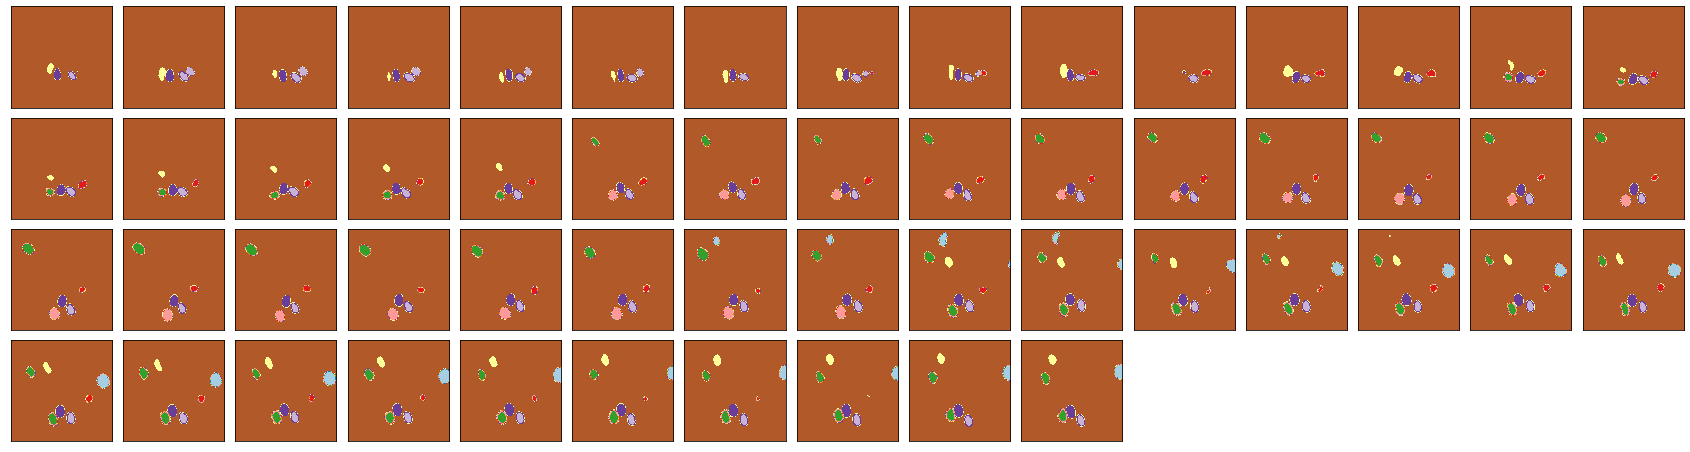

In [29]:
number_columns = 15
number_images = new_masks.shape[0]
number_rows = math.ceil(number_images/number_columns)
individual_figure_size = 2
# Loop to plot multiple cells in a grid
gs = gridspec.GridSpec(number_rows, number_columns)
gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
for index_image in range(0, number_images):
    ax = fig.add_subplot(gs[index_image])
    ax.imshow(new_masks[index_image], cmap = 'Paired_r',vmin=0,vmax=new_masks.max())
    ax.set_xticks([]); ax.set_yticks([])


# Cleaned codes to automatically segment cells

In [30]:
def cells_center_of_mass(list_masks_for_all_frames):
    # Creating dataframe with centers of mass
    list_df=[]
    number_frames= list_masks_for_all_frames.shape[0]
    for i in range(number_frames):
        number_cells_in_frame = list_masks_for_all_frames[i].max()
        for m in range (1, number_cells_in_frame+1):
            selected_mask = np.where(list_masks_for_all_frames[i]==m,1,0) # Selecting only one mask.  
            x,y = ndimage.measurements.center_of_mass(selected_mask)
            list_df.append( [i,int(x),int(y)] )
            del x, y, selected_mask
    return np.array(list_df)

In [31]:
def convert_mask_labels (masks,tracking_dataframe):
    list_df=[]
    number_frames= masks.shape[0]
    list_new_masks= []
    for i in range(0,number_frames):
        # creating a copy of the original image
        temp_image = np.zeros_like(masks[0,:,:])
        trackpy_labels = tracking_dataframe.loc[tracking_dataframe['frame']==i ].particle.values
        # Iterate for each cell in 
        number_cells_in_frame = masks[i].max()
        for m in range (1, number_cells_in_frame+1):
            selected_mask = np.where(masks[i]==m,1,0) # Selecting only one mask.  
            for index, particle_label in enumerate (trackpy_labels):
                # Test if the center of mass is inside the selected mask 
                y, x = tracking_dataframe.loc[(tracking_dataframe['frame']==i ) & (tracking_dataframe['particle']==particle_label) , ['y', 'x']].values[0]
                if selected_mask[y,x]==1:
                    temp_image = np.where(selected_mask==1, particle_label,temp_image)
        list_new_masks.append(temp_image)
    return np.array(list_new_masks)

In [51]:
number_optimization_steps = 3
#int_threshold_vector = np.linspace(2000,5000, num=number_optimization_steps, endpoint=True,dtype=int)
int_threshold_vector = np.round(np.linspace(0.9,0.99, num=number_optimization_steps, endpoint=True),2)
cell_size_vector = np.linspace(50,200, num=number_optimization_steps, endpoint=True,dtype=int)
model = models.Cellpose(gpu=use_GPU, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
print(int_threshold_vector)
print(cell_size_vector)

[0.9  0.94 0.99]
[ 50 125 200]


In [52]:

file_path = pathlib.Path(path_files[0])
video = imread(str(file_path)) 
img = np.expand_dims(video,axis=3)
image_optimization= np.concatenate((img,img),axis=3)

In [53]:
# optimization code to detected cells using multiple intensity thresholds
def cell_segmentation_optimized (image_to_segment, intensity_threshold,cell_size,model,minimal_trajectory_length= 5, masks_with_trackpy_labels= False): 
    image_test = image_to_segment.copy() # Making a copy of our img
    max_intensity_intensity_threshold = np.max(image_test)*intensity_threshold
    image_test[image_test>max_intensity_intensity_threshold]=max_intensity_intensity_threshold  # threshold image values larger than 1000 equal to 1000
    masks_for_all_frames, _, _, _ = model.eval(image_test, diameter=cell_size, min_size=500, channels=[0,0], net_avg=False, augment=False,flow_threshold=1)
    array_center_mass = cells_center_of_mass(masks_for_all_frames)
    df = pd.DataFrame(array_center_mass, columns=['frame', 'y', 'x'])
    try:
        t = tp.link(df, memory=0,search_range=100)
        t_filtered = tp.filter_stubs(t, minimal_trajectory_length)  # selecting trajectories that appear in at least 10 frames.
        num_detected_cells = t_filtered['particle'].nunique()
    except:
        num_detected_cells = 0
        t_filtered = pd.DataFrame([], columns=['frame', 'y', 'x'])
    if (masks_with_trackpy_labels == True) and (num_detected_cells>0) :
        masks= convert_mask_labels (masks=masks_for_all_frames,tracking_dataframe=t_filtered)
    else:
        masks= masks_for_all_frames
    return num_detected_cells, masks, t_filtered

In [54]:
# Optimization code
detected_cells_matrix = np.zeros((int_threshold_vector.shape[0],cell_size_vector.shape[0] ) )
for index_intensity, intensity_value in enumerate(int_threshold_vector):
    for index_cell_size, cell_size in enumerate(cell_size_vector):
        detected_cells_matrix[index_intensity,index_cell_size],_,_ = cell_segmentation_optimized (image_to_segment=image_optimization, intensity_threshold=intensity_value,cell_size=cell_size,model=model)

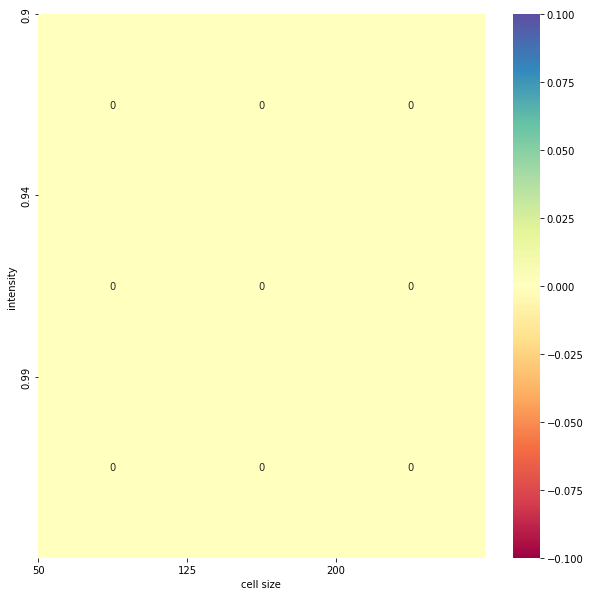

In [55]:
# showing optimization plot
tick_values= np.linspace(0, number_optimization_steps,num=number_optimization_steps,endpoint=False)
df_optimization = pd.DataFrame(detected_cells_matrix ) # Converting the image into a pandas data frame
fig, ax = plt.subplots(1,1,figsize=(10,10))
sn.heatmap(df_optimization, annot=True,cmap="Spectral",ax=ax)
ax.set_xlabel('cell size')
ax.set_ylabel('intensity')
ax.set_yticks(tick_values,int_threshold_vector)  
ax.set_xticks(tick_values,cell_size_vector)
plt.show()

In [56]:
# running for selected values
selected_intensity_index, selected_cell_size_index = unravel_index(detected_cells_matrix.argmax(), detected_cells_matrix.shape)
detected_cells, masks_final, t_filtered_final = cell_segmentation_optimized (image_to_segment=image_optimization, intensity_threshold=int_threshold_vector[selected_intensity_index],
                                                                                                        cell_size=cell_size_vector[selected_cell_size_index], model=model ,
                                                                                                        masks_with_trackpy_labels= True)

In [57]:
print(int_threshold_vector[selected_intensity_index], cell_size_vector[selected_cell_size_index])

0.9 50


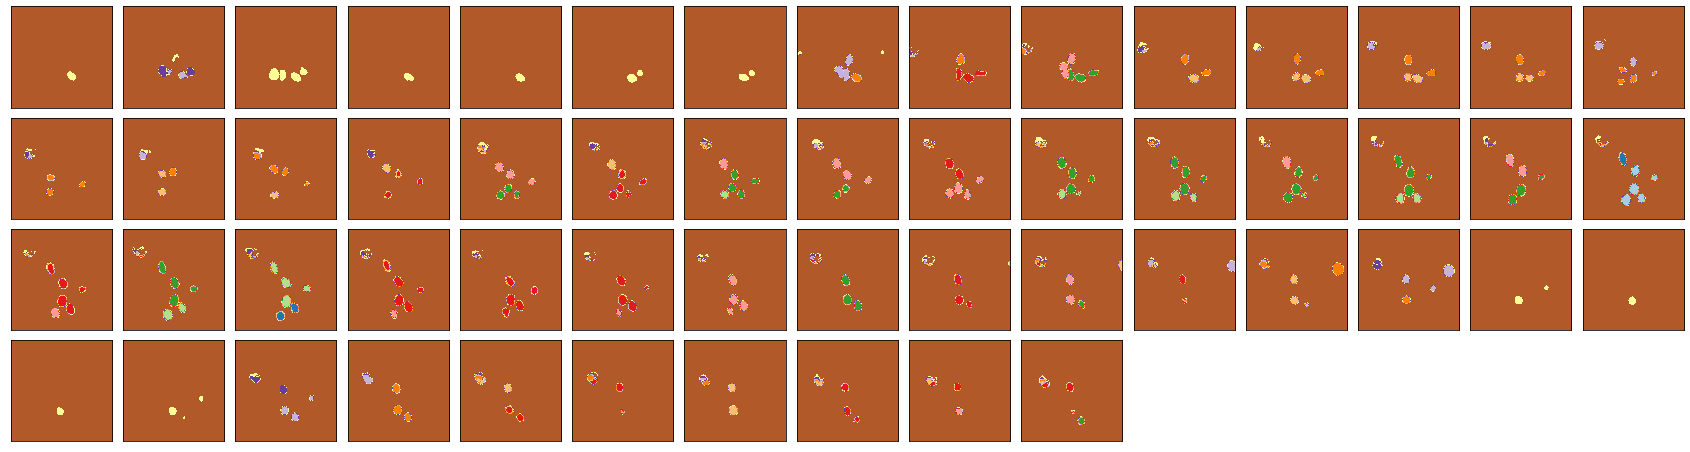

In [58]:
number_columns = 15
number_images = masks_final.shape[0]
number_rows = math.ceil(number_images/number_columns)
individual_figure_size = 2
# Loop to plot multiple cells in a grid
gs = gridspec.GridSpec(number_rows, number_columns)
gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
for index_image in range(0, number_images):
    ax = fig.add_subplot(gs[index_image])
    ax.imshow(masks_final[index_image], cmap = 'Paired_r',vmin=0,vmax=masks_final.max())
    ax.set_xticks([]); ax.set_yticks([])

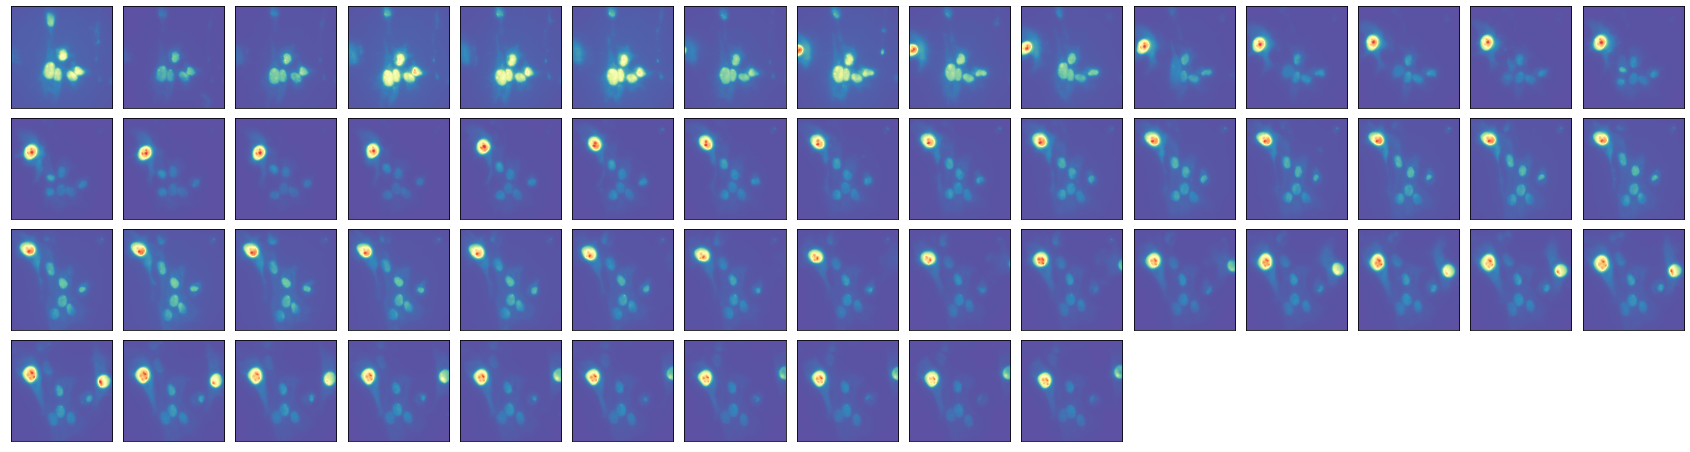

In [59]:
number_columns = 15
number_images = new_masks.shape[0]
number_rows = math.ceil(number_images/number_columns)
individual_figure_size = 2
# Loop to plot multiple cells in a grid
gs = gridspec.GridSpec(number_rows, number_columns)
gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
for index_image in range(0, number_images):
    ax = fig.add_subplot(gs[index_image])
    ax.imshow(image_optimization[index_image,:,:,0], cmap = 'Spectral_r')
    ax.set_xticks([]); ax.set_yticks([])

In [60]:
# Use filters to detect spots in cell

# perform particle tracking for ts

# plot ts trajectories (int, time)

